<a href="https://colab.research.google.com/github/oskar-furmanczuk/masters-thesis/blob/main/mgr_model_OFurmanczuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV
import shap
import time

In [4]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [7]:
# df = pd.read_csv("D:\REPOSITORY\masters-thesis\data\clean_COVID_Cases_Restricted_Detailed_02282021.xls")

df = pd.read_csv("/content/gdrive/MyDrive/dane-mgr/clean_COVID_Cases_Restricted_Detailed_02282021.csv")

In [8]:
df.head()

,race_ethnicity_combined,current_status,cdc_case_earliest_dt,sex,hosp_yn,icu_yn,death_yn,hc_work_yn,pna_yn,abxchest_yn,acuterespdistress_yn,mechvent_yn,fever_yn,sfever_yn,chills_yn,myalgia_yn,runnose_yn,sthroat_yn,cough_yn,sob_yn,nauseavomit_yn,headache_yn,abdom_yn,diarrhea_yn,medcond_yn,county_fips_code,res_county,res_state,age_group
0,"Black, Non-Hispanic",Laboratory-confirmed case,2020-09-09,Male,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes,No,Yes,No,No,No,Yes,No,No,No,39009.0,ATHENS,OH,10 - 19 Years
1,"Black, Non-Hispanic",Laboratory-confirmed case,2020-10-08,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Yes,No,No,No,39009.0,ATHENS,OH,10 - 19 Years
2,"Black, Non-Hispanic",Laboratory-confirmed case,2020-09-23,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,39009.0,ATHENS,OH,10 - 19 Years
3,"Black, Non-Hispanic",Laboratory-confirmed case,2020-10-08,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Yes,No,No,Yes,No,39009.0,ATHENS,OH,10 - 19 Years
4,"Multiple/Other, Non-Hispanic",Laboratory-confirmed case,2020-09-02,Male,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,39017.0,BUTLER,OH,60 - 69 Years


In [9]:
dates = df.cdc_case_earliest_dt.values

In [10]:
df["date_year"] = list(map(lambda x: int(x.split("-")[0]), dates))
df["date_month"] = list(map(lambda x: int(x.split("-")[1]), dates))
df["date_day"] = list(map(lambda x: int(x.split("-")[2]), dates))

In [11]:
df = df.drop("cdc_case_earliest_dt", axis=1)

In [12]:
df.head()

,race_ethnicity_combined,current_status,sex,hosp_yn,icu_yn,death_yn,hc_work_yn,pna_yn,abxchest_yn,acuterespdistress_yn,mechvent_yn,fever_yn,sfever_yn,chills_yn,myalgia_yn,runnose_yn,sthroat_yn,cough_yn,sob_yn,nauseavomit_yn,headache_yn,abdom_yn,diarrhea_yn,medcond_yn,county_fips_code,res_county,res_state,age_group,date_year,date_month,date_day
0,"Black, Non-Hispanic",Laboratory-confirmed case,Male,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes,No,Yes,No,No,No,Yes,No,No,No,39009.0,ATHENS,OH,10 - 19 Years,2020,9,9
1,"Black, Non-Hispanic",Laboratory-confirmed case,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Yes,No,No,No,39009.0,ATHENS,OH,10 - 19 Years,2020,10,8
2,"Black, Non-Hispanic",Laboratory-confirmed case,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,39009.0,ATHENS,OH,10 - 19 Years,2020,9,23
3,"Black, Non-Hispanic",Laboratory-confirmed case,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Yes,No,No,Yes,No,39009.0,ATHENS,OH,10 - 19 Years,2020,10,8
4,"Multiple/Other, Non-Hispanic",Laboratory-confirmed case,Male,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,39017.0,BUTLER,OH,60 - 69 Years,2020,9,2


In [13]:
df = df.replace("No", 0).replace("Yes", 1)
df = df.replace("Male", 1).replace("Female", 0)

In [14]:
# covid death rate in USA
df[df["death_yn"] == 1].shape[0] / ( df[df["death_yn"] == 0].shape[0] + df[df["death_yn"] == 1].shape[0] )

0.012816543505564156

In [15]:
df = df.drop("county_fips_code", axis=1)

In [16]:
for col in df.columns:
  try:
    df.loc[:, col] = pd.to_numeric(df[col])
  except:
    pass

In [17]:
df.dtypes

race_ethnicity_combined    object
current_status             object
sex                         int64
hosp_yn                     int64
icu_yn                      int64
death_yn                    int64
hc_work_yn                  int64
pna_yn                      int64
abxchest_yn                 int64
acuterespdistress_yn        int64
mechvent_yn                 int64
fever_yn                    int64
sfever_yn                   int64
chills_yn                   int64
myalgia_yn                  int64
runnose_yn                  int64
sthroat_yn                  int64
cough_yn                    int64
sob_yn                      int64
nauseavomit_yn              int64
headache_yn                 int64
abdom_yn                    int64
diarrhea_yn                 int64
medcond_yn                  int64
res_county                 object
res_state                  object
age_group                  object
date_year                   int64
date_month                  int64
date_day      

In [18]:
y = df.death_yn.values
X = df.drop("death_yn", axis=1)

In [19]:
X = pd.get_dummies(X)

In [ ]:
cor = X.corr()

In [ ]:
cor

,sex,hosp_yn,icu_yn,hc_work_yn,pna_yn,abxchest_yn,acuterespdistress_yn,mechvent_yn,fever_yn,sfever_yn,...,res_state_WY,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,age_group_50 - 59 Years,age_group_60 - 69 Years,age_group_70 - 79 Years,age_group_80+ Years
sex,1.000000,0.031481,0.036303,-0.232211,0.028350,0.027906,0.019701,0.028404,0.054016,0.022367,...,0.001194,0.022474,0.022818,-0.020131,-0.015042,-0.010350,0.003998,0.010506,0.015749,-0.012889
hosp_yn,0.031481,1.000000,0.416579,-0.045817,0.513720,0.518831,0.319527,0.261393,0.092937,0.041011,...,-0.005843,-0.032422,-0.074711,-0.090903,-0.061853,-0.032634,0.011184,0.075576,0.156487,0.177489
icu_yn,0.036303,0.416579,1.000000,-0.026123,0.356769,0.365755,0.402391,0.558852,0.063018,0.030338,...,-0.002520,-0.014456,-0.034948,-0.044746,-0.028901,-0.014623,0.008918,0.041554,0.071544,0.069123
hc_work_yn,-0.232211,-0.045817,-0.026123,1.000000,-0.024458,-0.021980,-0.014105,-0.019077,-0.008238,0.021139,...,-0.006821,-0.064999,-0.102998,0.075547,0.092079,0.058660,0.017012,-0.043239,-0.090740,-0.069542
pna_yn,0.028350,0.513720,0.356769,-0.024458,1.000000,0.765337,0.377864,0.264518,0.116789,0.071819,...,-0.001736,-0.031029,-0.062541,-0.073391,-0.035156,-0.008182,0.021712,0.056872,0.097092,0.105273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
age_group_40 - 49 Years,-0.010350,-0.032634,-0.014623,0.058660,-0.008182,-0.008994,-0.006202,-0.010984,0.023849,0.038337,...,-0.003363,-0.071865,-0.145752,-0.203224,-0.184963,1.000000,-0.185663,-0.157455,-0.109957,-0.078083
age_group_50 - 59 Years,0.003998,0.011184,0.008918,0.017012,0.021712,0.021461,0.005543,0.009236,0.035287,0.039382,...,-0.002090,-0.072933,-0.147918,-0.206244,-0.187712,-0.185663,1.000000,-0.159795,-0.111591,-0.079243
age_group_60 - 69 Years,0.010506,0.075576,0.041554,-0.043239,0.056872,0.056282,0.024310,0.027166,0.020040,0.013812,...,-0.003867,-0.061853,-0.125445,-0.174910,-0.159193,-0.157455,-0.159795,1.000000,-0.094637,-0.067204
age_group_70 - 79 Years,0.015749,0.156487,0.071544,-0.090740,0.097092,0.097280,0.062757,0.052054,-0.006176,-0.020989,...,-0.003366,-0.043194,-0.087603,-0.122146,-0.111170,-0.109957,-0.111591,-0.094637,1.000000,-0.046931


In [ ]:
l = []
for col in cor.columns:
  for idx in cor.columns:
    if cor.loc[idx, col] > 0.8 and idx != col:
      l.append((idx, col, cor.loc[idx, col]))
l

[('res_state_AK', 'res_county_ANCHORAGE', 0.8659975734609457),
 ('res_state_NV', 'res_county_CLARK', 0.8196529417316747),
 ('res_state_NJ', 'res_county_MONMOUTH', 1.0),
 ('res_state_WV', 'res_county_MONONGALIA', 1.0),
 ('res_state_AR', 'res_county_PULASKI', 1.0),
 ('res_state_NY', 'res_county_RENSSELAER', 1.0),
 ('res_county_ANCHORAGE', 'res_state_AK', 0.8659975734609457),
 ('res_county_PULASKI', 'res_state_AR', 1.0),
 ('res_county_MONMOUTH', 'res_state_NJ', 1.0),
 ('res_county_CLARK', 'res_state_NV', 0.8196529417316747),
 ('res_county_RENSSELAER', 'res_state_NY', 1.0),
 ('res_county_MONONGALIA', 'res_state_WV', 1.0)]

In [ ]:
df[df.res_state == "NY"]

,race_ethnicity_combined,current_status,sex,hosp_yn,icu_yn,death_yn,hc_work_yn,pna_yn,abxchest_yn,acuterespdistress_yn,...,headache_yn,abdom_yn,diarrhea_yn,medcond_yn,res_county,res_state,age_group,date_year,date_month,date_day
46297,"White, Non-Hispanic",Laboratory-confirmed case,1,1,0,0,0,0,0,0,...,0,0,0,0,RENSSELAER,NY,70 - 79 Years,2020,12,18
46298,"White, Non-Hispanic",Laboratory-confirmed case,1,1,0,0,0,0,1,0,...,1,0,0,1,RENSSELAER,NY,70 - 79 Years,2020,9,28
148488,"White, Non-Hispanic",Laboratory-confirmed case,0,1,0,0,0,0,1,0,...,1,1,1,1,RENSSELAER,NY,60 - 69 Years,2020,3,23


In [20]:
 # 0.2 - testowy, 0.2 - validacyjny, 0.6 - treningowy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [21]:
def find_best_params(X_train, y_train, X_val, y_val, params):

    def check_parameters(learning_rate, max_depth, min_child_weight, scale_pos_weight, gamma=0):
        model = XGBClassifier(
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            eval_metric="logloss",
            use_label_encoder=False,
            scale_pos_weight = scale_pos_weight
        )
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        
        return acc, f1
    
    
    best_sum = 0
    best_param = {
        "learning_rate":-1,
        "max_depth":-1,
        "min_child_weight":-1,
        "gamma":-1,
        "scale_pos_weight":-1
    }
    
    for learning_rate in params["learning_rate"]:
        for max_depth in params["max_depth"]:
            for min_child_weight in params["min_child_weight"]:
                for gamma in params["gamma"]:
                    for scale_pos_weight in params["scale_pos_weight"]:
                        
                        start = time.time()
                        acc, f1 = check_parameters(learning_rate=learning_rate, 
                                                   max_depth=max_depth, 
                                                   min_child_weight=min_child_weight,
                                                   scale_pos_weight=scale_pos_weight,
                                                   gamma=gamma)
                        end = time.time()
                        print(end - start)
                        
                        print("\nDokładność: {:.4f}; F1-score: {:.4f}".format(acc, f1))

                        if(best_sum < acc + f1):
                            print("NEW BEST")
                            best_param = {
                                "learning_rate": learning_rate,
                                "max_depth": max_depth,
                                "min_child_weight": min_child_weight,
                                "gamma": gamma,
                                "scale_pos_weight": scale_pos_weight
                                }
                            print(best_param)
                            best_sum = acc + f1 
    return best_param

In [22]:
parameters = {
 "learning_rate"    : [0.15, 0.20, 0.25 ] ,
 "max_depth"        : [ 2, 3, 7 ],
 "min_child_weight" : [ 3, 5, 7 ],
 "scale_pos_weight" : [ 1, 3, 5 ],
 "gamma"            : [ 0.0, 0.1 ]
    
 }

# parameters = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
#  "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
#  "min_child_weight" : [ 1, 3, 5, 7 ],
#  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#  "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [ ]:
best_params = find_best_params(X_train, y_train, X_val, y_val, parameters)

15.064919710159302

Dokładność: 0.9889; F1-score: 0.2852
NEW BEST
{'learning_rate': 0.15, 'max_depth': 2, 'min_child_weight': 3, 'gamma': 0.0, 'scale_pos_weight': 1}
16.049747943878174

Dokładność: 0.9861; F1-score: 0.4338
NEW BEST
{'learning_rate': 0.15, 'max_depth': 2, 'min_child_weight': 3, 'gamma': 0.0, 'scale_pos_weight': 3}
16.781575918197632

Dokładność: 0.9779; F1-score: 0.4109



KeyboardInterrupt



In [ ]:
print(best_params)

{'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.0, 'scale_pos_weight': 3}


Najlepsze parametry:
{'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.0, 'scale_pos_weight': 3}

In [23]:
best_model = XGBClassifier(
            learning_rate=0.2,
            max_depth=3,
            min_child_weight=5,
            gamma=0,
            eval_metric="logloss",
            use_label_encoder=False,
            scale_pos_weight = 3
        )

In [24]:
best_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

In [25]:
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nDokładność: {:.4f}; F1-score: {:.4f}".format(acc, f1))


Dokładność: 0.9851; F1-score: 0.4604


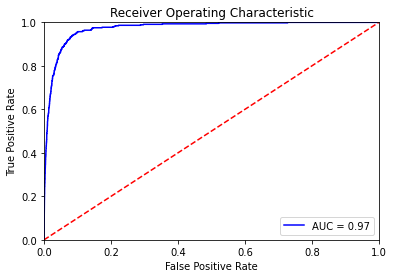

In [26]:
probs = best_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [27]:
confusion_matrix(y_test, y_pred)

array([[33508,   285],
       [  226,   218]])

In [28]:
explainer = shap.TreeExplainer(best_model)

In [36]:
shap_values_XGB_train = explainer.shap_values(X_train)

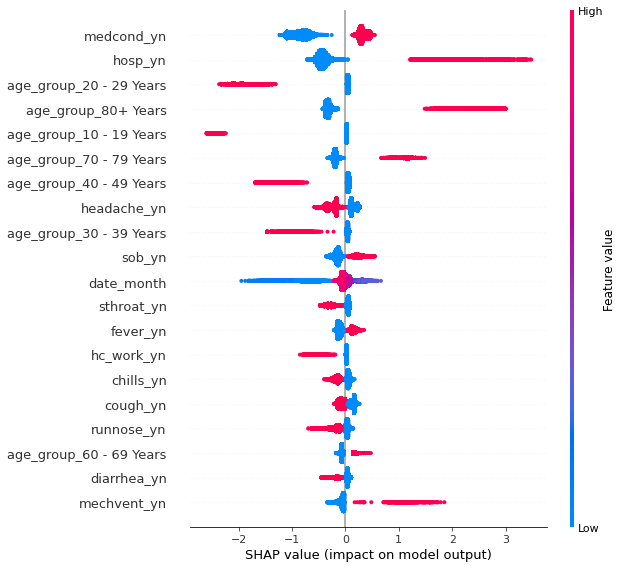

In [37]:
shap.summary_plot(shap_values_XGB_train, X_train)

In [29]:
shap_values_XGB_test = explainer.shap_values(X_test)

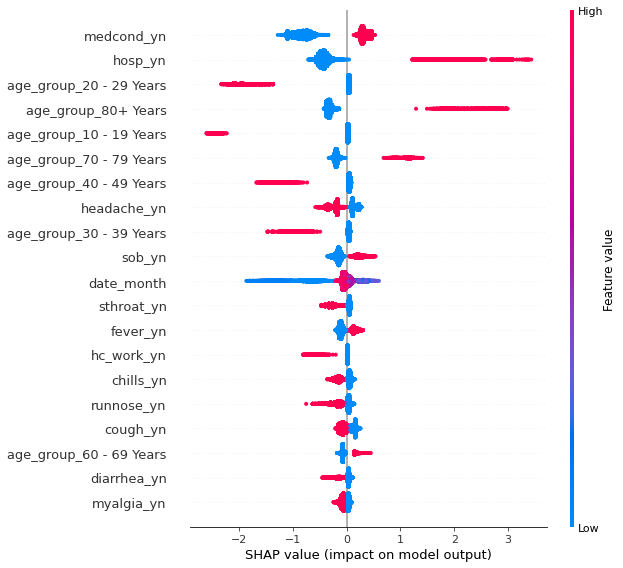

In [30]:
shap.summary_plot(shap_values_XGB_test, X_test)